# Backtesting Long-Term S&P 500 Investment Strategies for Dollar Cost Averaging, PE, and Shiller PE Ratio Triggers

## By: Jeff Hale

### "Buy low and sell high" is standard investment advice. 

However, investors buy when they think the price is going to rise and sell when they think the price is going to fall lower. Often times investors are chasing the market. They sell when fear has taken over and prices have already fallen. They buy when everyone is euphoric and prices are already high. 

In Nate Silver's book, *The Signal and the Noise*, he discusses how buying stocks when the 10 Year PE ratio (Shiller PE) is under 15 results in much better long term returns (pp. 346-350 paperback edition). 

Buying when stocks are valued cheaply - when one dollar of earnings is cheap relative to the historical average - should be a good investment strategy. But the proof is in the pudding, the devil is in the details, and the code needs written and run.

I'm certainly not the first person to test a value investment strategy like this one, but I'll look at various triggers for buying and selling. This is also a good exercise in building a basic back-testing process with python, pandas, and numpy.

Dollar cost averaging is another recommended investment strategy. Let's use that as a baseline. 

Rough plan:

1. Import S&P 500, PE, and Shiller PE monthly data, from [Quandl](https://www.quandl.com). 
2. Build DataFrames.
3. Code strategies to buy and sell based on triggers related to PE or Shiller PE ratios.  
4. Evaluate.
5. Iterate.

It's worth noting that average S&P annual PE ratios have been quite a bit higher since the 1990s than before, so we want to make sure we go back a good ways. The past thirty year's in the US economy have had their ups and downs, but money has largely been cheap and inflation has largely been low. We'll look at data going back 50 years for this example.

Let's code and and evaluate.

## Assumptions


For our simulations, let's say you are an individual investor with 1k of cash to invest per month. 

We'll assume you can invest this tax free in a retirement account. 

Transaction cost is assumed to be zero with [Vanguard](https://investor.vanguard.com/etf/profile/fees/voo) S&P 500 ETF (VOOO) because there is free to buy and sell.

Expense ratio is 0.04 percent.
Quarterly distributions per share have been over one dollar for past few quarters. 
Based on historic performance, there are expected to be no taxable capital gains distributions.
Shares are currently $229.64 as of Jan. 2, 2019, COB.

For now, we'll exclude the above concerns.

In [1]:
# essentials
import numpy as np 
import pandas as pd 

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# quandl
import quandl

# reproducibility
np.random.seed(34)

# Jupyter magic
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# formatting
sns.set()
pd.options.display.float_format = '{:,.2f}'.format

Let's get the S&P PE Ratio data. We'll specify that we want the result in a numpy array. Insert your own authtoken. Tokens are free at Quandl.

In [2]:
# Commenting out so don't ping the api. Uncomment first run.
sp_pe_data = quandl.get(
    "MULTPL/SP500_PE_RATIO_MONTH", 
    authtoken="17ShEkbGYrhcJ7Qw8DvJ",
    returns="numpy"
)

In [3]:
df_pe = pd.DataFrame(sp_pe_data)
df_pe.head()

,Date,Value
0,1871-01-01,11.10
1,1871-02-01,11.25
2,1871-03-01,11.52
3,1871-04-01,11.85
4,1871-05-01,12.15


In [4]:
df_pe.tail()

,Date,Value
1774,2018-10-01,21.36
1775,2018-11-01,20.89
1776,2018-11-30,22.52
1777,2018-12-01,20.19
1778,2018-12-28,19.06


Looks like we have some end of month dates and some start of month dates. Let's inspect more closely.

In [5]:
df_pe.tail(15)

,Date,Value
1764,2018-01-01,24.97
1765,2018-02-01,23.82
1766,2018-03-01,23.41
1767,2018-04-01,22.53
1768,2018-05-01,22.49
1769,2018-06-01,22.49
1770,2018-07-01,22.33
1771,2018-08-01,22.37
1772,2018-09-01,22.25
1773,2018-09-28,25.24


Looks like the end of month data is only present for a few recent dates: 9/28, 11/30, and 12/28. Let's remove those dates.

In [6]:
df_pe = df_pe.drop([1773, 1776, 1778])

In [7]:
df_pe.tail()

,Date,Value
1771,2018-08-01,22.37
1772,2018-09-01,22.25
1774,2018-10-01,21.36
1775,2018-11-01,20.89
1777,2018-12-01,20.19


Looks good. Let's find the average PE of the past 50 years.

In [8]:
AVG_PE = np.mean(df_pe.tail(600).Value)
AVG_PE

19.332349999999998

Alright 19.3 passes the smell test. It's about what you'd expect. Let's look at it graphically. 

In [9]:
df_pe_50 = df_pe.tail(600)
df_pe_50.tail()

,Date,Value
1771,2018-08-01,22.37
1772,2018-09-01,22.25
1774,2018-10-01,21.36
1775,2018-11-01,20.89
1777,2018-12-01,20.19


In [10]:
df_pe_50.mean()

Value   19.33
dtype: float64

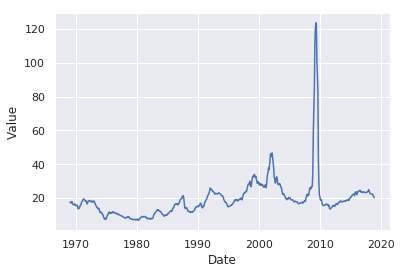

In [11]:
sns.lineplot(data=df_pe_50, x='Date', y='Value')

## Price Data

Cool. Now we need the S&P 500 prices, too. We can get inflation adjusted or non-inflation adjusted. We'll use inflation adjusted for real returns.

We'll eventually combine these into one DataFrame.

In [12]:
sp_price_data = quandl.get(
    "MULTPL/SP500_INFLADJ_MONTH", 
    authtoken="17ShEkbGYrhcJ7Qw8DvJ",
    returns="numpy"
)

In [13]:
df_price = pd.DataFrame(sp_price_data)
df_price.tail(20)

,Date,Value
1759,2017-08-01,"2,521.44"
1760,2017-09-01,"2,545.55"
1761,2017-10-01,"2,612.72"
1762,2017-11-01,"2,650.06"
1763,2017-12-01,"2,723.93"
1764,2018-01-01,"2,836.75"
1765,2018-02-01,"2,738.26"
1766,2018-03-01,"2,729.67"
1767,2018-04-01,"2,669.43"
1768,2018-05-01,"2,706.32"


Same deal. We have the same end of month dates. Let's drop those, take the past 50 years of data, and plot.

In [14]:
df_price = df_price.drop([1773, 1776, 1778])

In [15]:
df_price_50 = df_price.tail(600)
df_price_50.tail()

,Date,Value
1771,2018-08-01,"2,856.60"
1772,2018-09-01,"2,896.89"
1774,2018-10-01,"2,776.13"
1775,2018-11-01,"2,723.23"
1777,2018-12-01,"2,633.08"


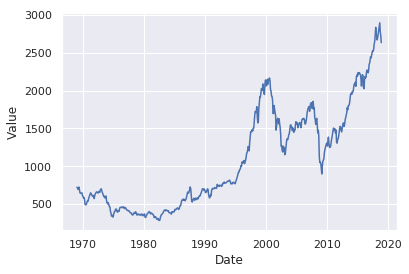

In [16]:
sns.lineplot(data=df_price_50, x='Date', y='Value')

That chart always makes me nervous. Stock market curves that go up like that usually come back to earth eventually. 

Let's combine the DataFrames.

In [17]:
df_50 = pd.merge(df_price_50, df_pe_50, on='Date', how='inner')
df_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 3 columns):
Date       600 non-null datetime64[ns]
Value_x    600 non-null float64
Value_y    600 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 18.8 KB


In [18]:
df_50.head()

,Date,Value_x,Value_y
0,1969-01-01,722.13,17.65
1,1969-02-01,714.58,17.50
2,1969-03-01,693.28,17.06
3,1969-04-01,703.35,17.39
4,1969-05-01,724.26,17.93


In [19]:
df_50.columns=['date', 'price', 'pe']

In [20]:
df_50.head()

,date,price,pe
0,1969-01-01,722.13,17.65
1,1969-02-01,714.58,17.50
2,1969-03-01,693.28,17.06
3,1969-04-01,703.35,17.39
4,1969-05-01,724.26,17.93


Let's plot both lines on the same plot.

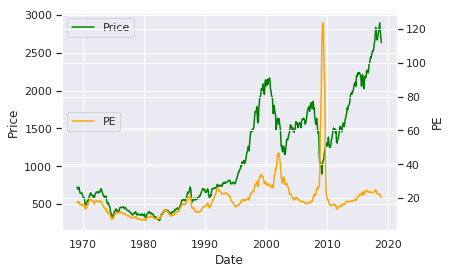

In [21]:
ax1 = sns.lineplot(data=df_50, x='date', y='price', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax2 = plt.twinx()
ax2 = sns.lineplot(data=df_50, x='date', y='pe', color='orange')
ax2.set_ylabel('PE')
ax1.legend(labels=["Price"], loc = 'upper left')
ax2.legend(labels=["PE"], loc = 'center left')

## Shiller PE

Let's add the Shiller PE, also. It's the 10 year PE, which helps smooth out business cycle effects, compared to the standard PE ratio.

In [22]:
sp_10pe_data = quandl.get(
    "MULTPL/SHILLER_PE_RATIO_MONTH",                     
    authtoken="17ShEkbGYrhcJ7Qw8DvJ",
    returns="numpy"
)

Let's make a DataFrame, drop the irrelevant values, and keep only the past 50 years.

In [23]:
df_10 = pd.DataFrame(sp_10pe_data)
df_10.tail()

,Date,Value
1773,2018-10-01,31.04
1774,2018-11-01,30.31
1775,2018-11-30,30.94
1776,2018-12-01,29.14
1777,2018-12-28,27.51


In [24]:
df_10 = df_10.drop([1772, 1775, 1777])

In [25]:
df_10.tail(20)

,Date,Value
1755,2017-05-01,29.31
1756,2017-06-01,29.75
1757,2017-07-01,30.00
1758,2017-08-01,29.91
1759,2017-09-01,30.17
1760,2017-10-01,30.92
1761,2017-11-01,31.30
1762,2017-12-01,32.09
1763,2018-01-01,33.31
1764,2018-02-01,32.04


In [26]:
df_10pe_50 = df_10.tail(600)
df_10pe_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 1175 to 1776
Data columns (total 2 columns):
Date     600 non-null datetime64[ns]
Value    600 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.1 KB


In [27]:
df_10pe_50.columns=['date', 'shiller_pe']
df_10pe_50.tail()

,date,shiller_pe
1770,2018-08-01,32.39
1771,2018-09-01,32.62
1773,2018-10-01,31.04
1774,2018-11-01,30.31
1776,2018-12-01,29.14


Let's combine the Shiller PE data into the main DataFrame.

In [28]:
df_50 = pd.merge(df_50, df_10pe_50, on='date', how='inner')
df_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600 entries, 0 to 599
Data columns (total 4 columns):
date          600 non-null datetime64[ns]
price         600 non-null float64
pe            600 non-null float64
shiller_pe    600 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 23.4 KB


In [29]:
df_50.tail()

,date,price,pe,shiller_pe
595,2018-08-01,"2,856.60",22.37,32.39
596,2018-09-01,"2,896.89",22.25,32.62
597,2018-10-01,"2,776.13",21.36,31.04
598,2018-11-01,"2,723.23",20.89,30.31
599,2018-12-01,"2,633.08",20.19,29.14


In [30]:
#df_50 = df_50.set_index('date')
#df_50.head()

To see graphically:

/Users/jeffhale/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:493: UserWarning: Unrecognized location "bottom left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


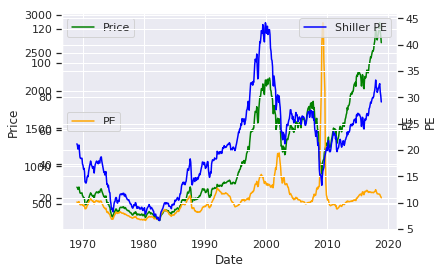

In [31]:
from matplotlib import rcParams

ax1 = sns.lineplot(data=df_50, x='date', y='price', color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend(labels=["Price"], loc = 'upper left')

ax2 = plt.twinx()
ax2 = sns.lineplot(data=df_50, x='date', y='pe', color='orange')
ax2.set_ylabel('PE')
ax2.legend(labels=["PE"], loc = 'center left')

ax3 = plt.twinx()
ax3 = sns.lineplot(data=df_50, x='date', y='shiller_pe', color='blue')
ax3.set_ylabel('PE')
ax3.legend(labels=["Shiller PE"], loc = 'bottom left')

rcParams['figure.figsize'] = 20,10

That's a bit tough to read.

## Strategy
Now let's implement our trading strategy. First we'll try buying when PE is low and selling when it is high.

Let's try buying when the PE is 1 standard deviation below the average over the whole period (could also try 1 SD below average for past 50 years at that point in time).

In [32]:
df_50.std()

price        663.88
pe            12.67
shiller_pe     8.54
dtype: float64

12.7 is a big standard deviation. We won't ever be buying if we need to be one standard deviation below the mean. Let's try buying when we're half a standard deviation below the mean.

In [33]:
buy_pe = AVG_PE - (0.5 * df_50['pe'].std())
buy_pe = 15

Ok. Buying at a PE just under 13 is reasonable. Let's make our index the data.

In [34]:
df_50 = df_50.set_index('date')
df_50.head()

,price,pe,shiller_pe
date,,,
1969-01-01,722.13,17.65,21.19
1969-02-01,714.58,17.50,20.90
1969-03-01,693.28,17.06,20.20
1969-04-01,703.35,17.39,20.43
1969-05-01,724.26,17.93,20.97


Let's add a column for the % change in price

In [35]:
df_50['pct_change'] = df_50['price'].pct_change()
df_50.tail()

,price,pe,shiller_pe,pct_change
date,,,,
2018-08-01,"2,856.60",22.37,32.39,0.02
2018-09-01,"2,896.89",22.25,32.62,0.01
2018-10-01,"2,776.13",21.36,31.04,-0.04
2018-11-01,"2,723.23",20.89,30.31,-0.02
2018-12-01,"2,633.08",20.19,29.14,-0.03


Let's make a DataFrame to keep track of our balance. 

In [36]:
df_balance = pd.DataFrame(np.zeros((600, 3)), index = df_50.index)

In [37]:
df_balance.head()

,0,1,2
date,,,
1969-01-01,0.00,0.00,0.00
1969-02-01,0.00,0.00,0.00
1969-03-01,0.00,0.00,0.00
1969-04-01,0.00,0.00,0.00
1969-05-01,0.00,0.00,0.00


In [38]:
df_balance.columns = ['cash_bal', 'invested_bal', 'signal']
df_balance.head()

,cash_bal,invested_bal,signal
date,,,
1969-01-01,0.00,0.00,0.00
1969-02-01,0.00,0.00,0.00
1969-03-01,0.00,0.00,0.00
1969-04-01,0.00,0.00,0.00
1969-05-01,0.00,0.00,0.00


Let's join these DataFrames together.

In [39]:
df_balance = df_balance.join(df_50, how="outer")
df_balance.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change
date,,,,,,,
1969-01-01,0.00,0.00,0.00,722.13,17.65,21.19,nan
1969-02-01,0.00,0.00,0.00,714.58,17.50,20.90,-0.01
1969-03-01,0.00,0.00,0.00,693.28,17.06,20.20,-0.03
1969-04-01,0.00,0.00,0.00,703.35,17.39,20.43,0.01
1969-05-01,0.00,0.00,0.00,724.26,17.93,20.97,0.03


## Variables 
Let's set our variables. We have 1k per month of new cash in from our non-investment earnings (e.g. our wages).

We'll sell half our invested capital if our sell signal is reached.
We'll buy with half our remaining account balance if our buy signal is reached.

In [40]:
monthly_new_capital = 1000
monthly_sell_amt = .20
monthly_buy_amt = .20

In [41]:
def allocate_gain_loss():
    # change invested balance by gain or loss since the past month
    df_balance['invested_bal'] *= df_balance['pct_change']
    df_balance.tail()

Use *np.select* to set create the buy, sell, and hold signals.

In [42]:
conditions = [
    ((df_balance['pe'] >= buy_pe) & (df_balance['pe'] < (2 * buy_pe))), 
    (df_balance['pe'] >= (2 * buy_pe))
]

choices = [0, -1]
    
df_balance['signal'] = np.select(conditions, choices, default=1)

df_balance.tail()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change
date,,,,,,,
2018-08-01,0.00,0.00,0,"2,856.60",22.37,32.39,0.02
2018-09-01,0.00,0.00,0,"2,896.89",22.25,32.62,0.01
2018-10-01,0.00,0.00,0,"2,776.13",21.36,31.04,-0.04
2018-11-01,0.00,0.00,0,"2,723.23",20.89,30.31,-0.02
2018-12-01,0.00,0.00,0,"2,633.08",20.19,29.14,-0.03


In [43]:
df_balance.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change
date,,,,,,,
1969-01-01,0.00,0.00,0,722.13,17.65,21.19,nan
1969-02-01,0.00,0.00,0,714.58,17.50,20.90,-0.01
1969-03-01,0.00,0.00,0,693.28,17.06,20.20,-0.03
1969-04-01,0.00,0.00,0,703.35,17.39,20.43,0.01
1969-05-01,0.00,0.00,0,724.26,17.93,20.97,0.03


In [44]:
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 1969-01-01 to 2018-12-01
Data columns (total 7 columns):
cash_bal        600 non-null float64
invested_bal    600 non-null float64
signal          600 non-null int64
price           600 non-null float64
pe              600 non-null float64
shiller_pe      600 non-null float64
pct_change      599 non-null float64
dtypes: float64(6), int64(1)
memory usage: 37.5 KB


In [45]:
df_balance = df_balance.fillna(0)
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 600 entries, 1969-01-01 to 2018-12-01
Data columns (total 7 columns):
cash_bal        600 non-null float64
invested_bal    600 non-null float64
signal          600 non-null int64
price           600 non-null float64
pe              600 non-null float64
shiller_pe      600 non-null float64
pct_change      600 non-null float64
dtypes: float64(6), int64(1)
memory usage: 37.5 KB


In [46]:
df_balance.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change
date,,,,,,,
1969-01-01,0.00,0.00,0,722.13,17.65,21.19,0.00
1969-02-01,0.00,0.00,0,714.58,17.50,20.90,-0.01
1969-03-01,0.00,0.00,0,693.28,17.06,20.20,-0.03
1969-04-01,0.00,0.00,0,703.35,17.39,20.43,0.01
1969-05-01,0.00,0.00,0,724.26,17.93,20.97,0.03


Seed a $1,000 initial investment

In [47]:
df_balance.loc['1969-01-01', 'invested_bal'] = 0  
df_balance.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change
date,,,,,,,
1969-01-01,0.00,0.00,0,722.13,17.65,21.19,0.00
1969-02-01,0.00,0.00,0,714.58,17.50,20.90,-0.01
1969-03-01,0.00,0.00,0,693.28,17.06,20.20,-0.03
1969-04-01,0.00,0.00,0,703.35,17.39,20.43,0.01
1969-05-01,0.00,0.00,0,724.26,17.93,20.97,0.03


In [48]:
import pdb

cash_bal = 1000                                # initial cash_bal
invested_bal = 0                               # initial invested_bal

for i, row in df_balance.iloc[1:].iterrows():
        
        # add outside contribution to cash balance
        df_balance.loc[i, 'cash_bal'] = cash_bal + monthly_new_capital
        cash_bal =  df_balance.loc[i, 'cash_bal']
        

        # change invested balance by gain or loss since the past month
        df_balance.loc[i, 'invested_bal'] = (1 + df_balance.loc[i, 'pct_change']) * invested_bal

        # buy, sell, or hold
        if df_balance.loc[i,'signal'] == 1:
            new_investment = monthly_buy_amt * cash_bal
      
            df_balance.loc[i, 'invested_bal'] = invested_bal + new_investment 
            
            df_balance.loc[i, 'cash_bal'] = cash_bal - new_investment

        if df_balance.loc[i,'signal'] == -1:
  
            withdrawal = monthly_sell_amt * invested_bal
       
            df_balance.loc[i, 'invested_bal'] = invested_bal - withdrawal
            df_balance.loc[i, 'cash_bal'] = cash_bal + withdrawal
            
        cash_bal = df_balance.loc[i, 'cash_bal']
        invested_bal = df_balance.loc[i, 'invested_bal']

In [49]:
df_balance.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change
date,,,,,,,
1969-01-01,0.00,0.00,0,722.13,17.65,21.19,0.00
1969-02-01,"2,000.00",0.00,0,714.58,17.50,20.90,-0.01
1969-03-01,"3,000.00",0.00,0,693.28,17.06,20.20,-0.03
1969-04-01,"4,000.00",0.00,0,703.35,17.39,20.43,0.01
1969-05-01,"5,000.00",0.00,0,724.26,17.93,20.97,0.03


In [50]:
df_balance.tail()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change
date,,,,,,,
2018-08-01,"361,696.41","1,561,508.68",0,"2,856.60",22.37,32.39,0.02
2018-09-01,"362,696.41","1,583,532.48",0,"2,896.89",22.25,32.62,0.01
2018-10-01,"363,696.41","1,517,521.21",0,"2,776.13",21.36,31.04,-0.04
2018-11-01,"364,696.41","1,488,604.39",0,"2,723.23",20.89,30.31,-0.02
2018-12-01,"365,696.41","1,439,325.52",0,"2,633.08",20.19,29.14,-0.03


In [51]:
df_balance['total'] = df_balance['cash_bal'] + df_balance['invested_bal'] 

In [52]:
df_balance['returns'] = df_balance['total'].pct_change()
df_balance.head(20)

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
1969-01-01,0.00,0.00,0,722.13,17.65,21.19,0.00,0.00,nan
1969-02-01,"2,000.00",0.00,0,714.58,17.50,20.90,-0.01,"2,000.00",inf
1969-03-01,"3,000.00",0.00,0,693.28,17.06,20.20,-0.03,"3,000.00",0.50
1969-04-01,"4,000.00",0.00,0,703.35,17.39,20.43,0.01,"4,000.00",0.33
1969-05-01,"5,000.00",0.00,0,724.26,17.93,20.97,0.03,"5,000.00",0.25
1969-06-01,"6,000.00",0.00,0,682.71,16.98,19.71,-0.06,"6,000.00",0.20
1969-07-01,"7,000.00",0.00,0,648.66,16.17,18.68,-0.05,"7,000.00",0.17
1969-08-01,"8,000.00",0.00,0,641.54,16.04,18.43,-0.01,"8,000.00",0.14
1969-09-01,"9,000.00",0.00,0,642.05,16.05,18.40,0.00,"9,000.00",0.12


In [53]:
df_balance.tail(20)

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
2017-05-01,"346,696.41","1,348,458.90",0,"2,466.85",23.31,29.31,0.01,"1,695,155.31",0.01
2017-06-01,"347,696.41","1,368,968.53",0,"2,504.37",23.40,29.75,0.02,"1,716,664.94",0.01
2017-07-01,"348,696.41","1,381,229.48",0,"2,526.80",23.36,30.00,0.01,"1,729,925.89",0.01
2017-08-01,"349,696.41","1,378,299.54",0,"2,521.44",23.16,29.91,-0.00,"1,727,995.95",-0.00
2017-09-01,"350,696.41","1,391,478.83",0,"2,545.55",23.28,30.17,0.01,"1,742,175.24",0.01
2017-10-01,"351,696.41","1,428,196.10",0,"2,612.72",23.67,30.92,0.03,"1,779,892.51",0.02
2017-11-01,"352,696.41","1,448,607.33",0,"2,650.06",23.81,31.30,0.01,"1,801,303.74",0.01
2017-12-01,"353,696.41","1,488,987.03",0,"2,723.93",24.25,32.09,0.03,"1,842,683.44",0.02
2018-01-01,"354,696.41","1,550,658.04",0,"2,836.75",24.97,33.31,0.04,"1,905,354.45",0.03


In [54]:
df_balance.signal.value_counts()

 0    366
 1    193
-1     41
Name: signal, dtype: int64

Let's compute the annualized Sharp ratio

In [55]:
returns = df_balance.returns
sharpe_ratio = np.sqrt(12) * (returns.mean() / returns.std())
sharpe_ratio

nan

## Chart It
Let's chart the total balance with the component cash and invested balances.

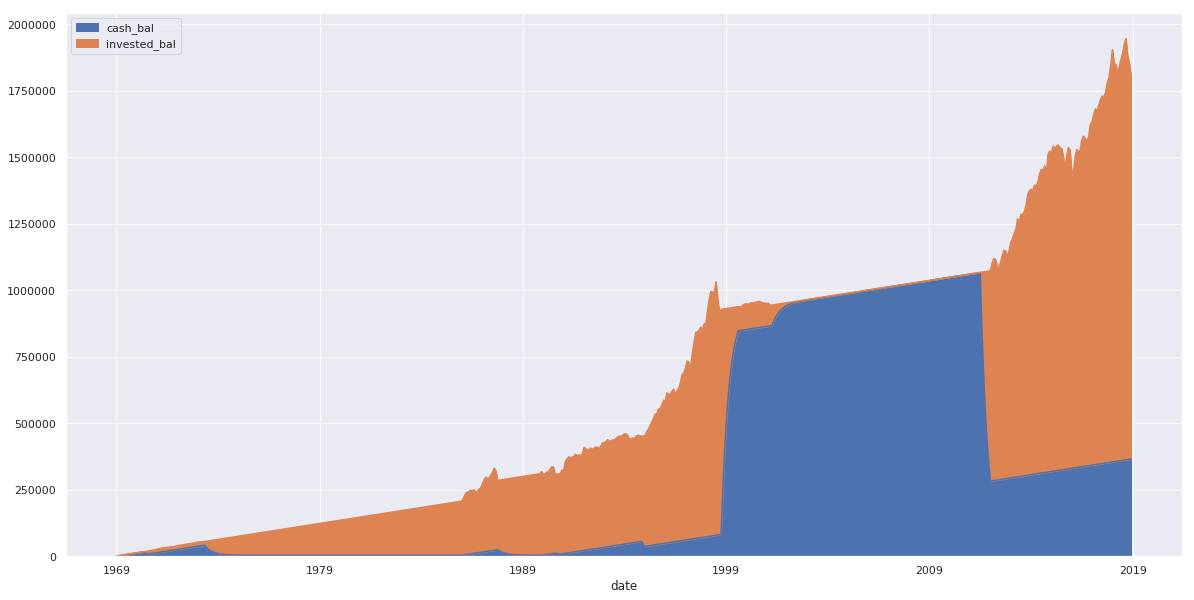

In [56]:
df_balance.loc[:, ['cash_bal', 'invested_bal']].plot.area()

That looks good. We have about 3x the amount we would have compared to uninflation adjusted hiding our 1k per month under the mattress. Let's make a stronger baseline comparison by looking at what happens when we just invest the 1k each month.

# Baseline: invest 1k per month in index fund

In [57]:
df_baseline = df_balance.copy()
df_baseline.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
1969-01-01,0.00,0.00,0,722.13,17.65,21.19,0.00,0.00,nan
1969-02-01,"2,000.00",0.00,0,714.58,17.50,20.90,-0.01,"2,000.00",inf
1969-03-01,"3,000.00",0.00,0,693.28,17.06,20.20,-0.03,"3,000.00",0.50
1969-04-01,"4,000.00",0.00,0,703.35,17.39,20.43,0.01,"4,000.00",0.33
1969-05-01,"5,000.00",0.00,0,724.26,17.93,20.97,0.03,"5,000.00",0.25


In [58]:
df_baseline['cash_bal'] = 0
df_baseline['invested_bal'] = 0
df_baseline['pct_change'] = df_50['price'].pct_change()
df_baseline = df_baseline.fillna(0)
df_baseline.tail()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
2018-08-01,0,0,0,"2,856.60",22.37,32.39,0.02,"1,923,205.09",0.02
2018-09-01,0,0,0,"2,896.89",22.25,32.62,0.01,"1,946,228.89",0.01
2018-10-01,0,0,0,"2,776.13",21.36,31.04,-0.04,"1,881,217.63",-0.03
2018-11-01,0,0,0,"2,723.23",20.89,30.31,-0.02,"1,853,300.80",-0.01
2018-12-01,0,0,0,"2,633.08",20.19,29.14,-0.03,"1,805,021.93",-0.03


In [59]:
df_baseline.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
1969-01-01,0,0,0,722.13,17.65,21.19,0.00,0.00,0.00
1969-02-01,0,0,0,714.58,17.50,20.90,-0.01,"2,000.00",inf
1969-03-01,0,0,0,693.28,17.06,20.20,-0.03,"3,000.00",0.50
1969-04-01,0,0,0,703.35,17.39,20.43,0.01,"4,000.00",0.33
1969-05-01,0,0,0,724.26,17.93,20.97,0.03,"5,000.00",0.25


# Make a nice, reusable function

In [60]:
def invest(
    df, 
    initial_cash=0,
    initial_investment=0,
    monthly_sell_amt=0.20, 
    monthly_buy_amt=1.0,
    monthly_new_capital=1000, 
    indicator='pe',
    baseline_indicator=10,
    buy_ratio=0.5,
    sell_ratio=2.0,
):
    '''
    Takes a DataFrame and fills it with trading strategy results
    
    parameters:
    df (pandas DataFrame): the DataFrame with the investment data
    initial_cash=0 (int): cash balance at start
    initial_investment=0 (int): first month's investment
    monthly_sell_amt=.20 (float): % cash to invest per buy
    monthly_buy_amt=.20 (float): % investment to sell per sale
    monthly_new_capital=1000 (int): cash contributed monthly
    indicator='pe'(string): name of series that will be the indicator
    baseline_indicator=10, (int): indicator value at for buy and sell ratios
    buy_ratio=0.5: indicator point at which to buy
    sell_ratio=2.0: indicator point at which to sell
    
    '''
    
    conditions = [
    ((df[indicator] >= (buy_ratio * baseline_indicator)) & (df[indicator] < (sell_ratio * baseline_indicator))), # hold
    (df[indicator] >= (sell_ratio * baseline_indicator)) # sell
    ]

    choices = [0, -1] # hold, sell
    
    # set signals
    df['signal'] = np.select(conditions, choices, default=1) # default is buy

    cash_bal = initial_cash                 # initial cash_bal
    invested_bal = initial_investment       # initial invested_bal
    
    # set cash balance for first month
    df.iloc[0,0] = cash_bal
    
    # set initial investment balance for first month
    df.iloc[0,1] = invested_bal
    
    # set cash balance for first month
    df.iloc[0,0] = cash_bal
    
  
    # iterate through rows starting at second month
    for i, row in df.iloc[1:].iterrows():

        # add outside contribution to cash balance
        df.loc[i, 'cash_bal'] = cash_bal + monthly_new_capital
        cash_bal =  df.loc[i, 'cash_bal']

        # change invested balance by gain or loss over the past month
        df.loc[i, 'invested_bal'] = ((1 + df.loc[i, 'pct_change']) * invested_bal)

        # buy, sell, or hold
        if df.loc[i,'signal'] == 1:
            new_investment = monthly_buy_amt * cash_bal

            df.loc[i, 'invested_bal'] =  df.loc[i, 'invested_bal'] + new_investment 

            df.loc[i, 'cash_bal'] = cash_bal - new_investment

        if df.loc[i,'signal'] == -1:

            withdrawal = monthly_sell_amt * invested_bal

            df.loc[i, 'invested_bal'] =  df.loc[i, 'invested_bal'] - withdrawal
            df.loc[i, 'cash_bal'] = cash_bal + withdrawal

        cash_bal = df.loc[i, 'cash_bal']
        invested_bal = df.loc[i, 'invested_bal']
        
    df['total'] = df['cash_bal'] + df['invested_bal'] 
    df['returns'] = df['pct_change'].cumsum()
    

## Baseline 
Invest 1k per month in S&P 500 EFT.

In [61]:
invest(
    df_baseline, 
    initial_investment=1000, 
    baseline_indicator=1000
)
df_baseline.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
1969-01-01,0.00,"1,000.00",1,722.13,17.65,21.19,0.00,"1,000.00",0.00
1969-02-01,0.00,"1,989.54",1,714.58,17.50,20.90,-0.01,"1,989.54",-0.01
1969-03-01,0.00,"2,930.24",1,693.28,17.06,20.20,-0.03,"2,930.24",-0.04
1969-04-01,0.00,"3,972.80",1,703.35,17.39,20.43,0.01,"3,972.80",-0.03
1969-05-01,0.00,"5,090.91",1,724.26,17.93,20.97,0.03,"5,090.91",0.00


In [62]:
df_baseline.tail()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
2018-08-01,0.00,"2,339,803.61",1,"2,856.60",22.37,32.39,0.02,"2,339,803.61",1.77
2018-09-01,0.00,"2,373,804.62",1,"2,896.89",22.25,32.62,0.01,"2,373,804.62",1.79
2018-10-01,0.00,"2,275,850.01",1,"2,776.13",21.36,31.04,-0.04,"2,275,850.01",1.74
2018-11-01,0.00,"2,233,482.99",1,"2,723.23",20.89,30.31,-0.02,"2,233,482.99",1.73
2018-12-01,0.00,"2,160,545.61",1,"2,633.08",20.19,29.14,-0.03,"2,160,545.61",1.69


In [63]:
df_baseline.signal.value_counts()

1    600
Name: signal, dtype: int64

## Test with PE

In [64]:
df_pe = df_baseline.copy()

In [65]:
invest(
    df_pe, 
    initial_investment=0, 
    monthly_sell_amt=0.90,
    monthly_buy_amt=0.90,
    initial_cash=1000,
    baseline_indicator=15,
    indicator='pe'
)

In [66]:
df_pe.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
1969-01-01,"1,000.00",0.00,0,722.13,17.65,21.19,0.00,"1,000.00",0.00
1969-02-01,"2,000.00",0.00,0,714.58,17.50,20.90,-0.01,"2,000.00",-0.01
1969-03-01,"3,000.00",0.00,0,693.28,17.06,20.20,-0.03,"3,000.00",-0.04
1969-04-01,"4,000.00",0.00,0,703.35,17.39,20.43,0.01,"4,000.00",-0.03
1969-05-01,"5,000.00",0.00,0,724.26,17.93,20.97,0.03,"5,000.00",0.00


In [67]:
df_pe.tail()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
2018-08-01,"1,261,610.23",0.00,0,"2,856.60",22.37,32.39,0.02,"1,261,610.23",1.77
2018-09-01,"1,262,610.23",0.00,0,"2,896.89",22.25,32.62,0.01,"1,262,610.23",1.79
2018-10-01,"1,263,610.23",0.00,0,"2,776.13",21.36,31.04,-0.04,"1,263,610.23",1.74
2018-11-01,"1,264,610.23",0.00,0,"2,723.23",20.89,30.31,-0.02,"1,264,610.23",1.73
2018-12-01,"1,265,610.23",0.00,0,"2,633.08",20.19,29.14,-0.03,"1,265,610.23",1.69


In [68]:
df_pe.signal.value_counts()
# 0 = hold
# 1 = buy
# -1 = sell

 0    545
-1     41
 1     14
Name: signal, dtype: int64

That isn't performing very well compard to dollar cost averaging baseline scenario. Feel free to play with the parameters, but PE isn't a great leading indicator, it appears.

## Test with Shiller PE

In [69]:
df_shiller_pe = df_baseline.copy()

In [70]:
invest(
    df_shiller_pe, 
    initial_investment=0, 
    monthly_sell_amt=1.0,
    monthly_buy_amt=1.0,
    initial_cash=1000,
    baseline_indicator=15,
    indicator='shiller_pe',
    buy_ratio=.9,
    sell_ratio=2.5
)

In [71]:
df_shiller_pe.head()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
1969-01-01,"1,000.00",0.00,0,722.13,17.65,21.19,0.00,"1,000.00",0.00
1969-02-01,"2,000.00",0.00,0,714.58,17.50,20.90,-0.01,"2,000.00",-0.01
1969-03-01,"3,000.00",0.00,0,693.28,17.06,20.20,-0.03,"3,000.00",-0.04
1969-04-01,"4,000.00",0.00,0,703.35,17.39,20.43,0.01,"4,000.00",-0.03
1969-05-01,"5,000.00",0.00,0,724.26,17.93,20.97,0.03,"5,000.00",0.00


In [72]:
df_shiller_pe.tail()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
2018-08-01,"113,000.00","3,864,177.85",0,"2,856.60",22.37,32.39,0.02,"3,977,177.85",1.77
2018-09-01,"114,000.00","3,918,678.91",0,"2,896.89",22.25,32.62,0.01,"4,032,678.91",1.79
2018-10-01,"115,000.00","3,755,324.53",0,"2,776.13",21.36,31.04,-0.04,"3,870,324.53",1.74
2018-11-01,"116,000.00","3,683,765.68",0,"2,723.23",20.89,30.31,-0.02,"3,799,765.68",1.73
2018-12-01,"117,000.00","3,561,818.04",0,"2,633.08",20.19,29.14,-0.03,"3,678,818.04",1.69


In [73]:
df_shiller_pe.signal.value_counts()
# 0 = hold
# 1 = buy
# -1 = sell

 0    424
 1    151
-1     25
Name: signal, dtype: int64

We found a really great outcome, but we peaked into the future to find it (and I tried a fair number of times). It is far too brittle. Our model is overfitting.

invest(
    df_shiller_pe, 
    initial_investment=0, 
    monthly_sell_amt=1.0,
    monthly_buy_amt=1.0,
    initial_cash=1000,
    baseline_indicator=15,
    indicator='shiller_pe',
    buy_ratio=0.9,
    sell_ratio=2.5
)

When we drop the sell ratio to 2 and the buy ratio to .5 and what do we get?

In [74]:
invest(
    df_shiller_pe, 
    initial_investment=0, 
    monthly_sell_amt=1.0,
    monthly_buy_amt=1.0,
    initial_cash=1000,
    baseline_indicator=15,
    indicator='shiller_pe',
    buy_ratio=0.5,
    sell_ratio=2.0
)
df_shiller_pe.tail()

,cash_bal,invested_bal,signal,price,pe,shiller_pe,pct_change,total,returns
date,,,,,,,,,
2018-08-01,"1,159,962.49",0.00,-1,"2,856.60",22.37,32.39,0.02,"1,159,962.49",1.77
2018-09-01,"1,160,962.49",0.00,-1,"2,896.89",22.25,32.62,0.01,"1,160,962.49",1.79
2018-10-01,"1,161,962.49",-0.00,-1,"2,776.13",21.36,31.04,-0.04,"1,161,962.49",1.74
2018-11-01,"1,162,962.49",0.00,-1,"2,723.23",20.89,30.31,-0.02,"1,162,962.49",1.73
2018-12-01,"1,163,962.49",0.00,0,"2,633.08",20.19,29.14,-0.03,"1,163,962.49",1.69


We get an outcome far worse than our baseline of just investing 1k per month in the S&P 500 index fund. Looks like timing the market based on Shiller PE is tough, too!

# Conclusion
## Future directions

It isn't easy to beat the market. Adequately testing a long-term strategy -  even one as basic as the ones here here will take more work. Check out [this really good interview](https://blog.quandl.com/interview-with-a-quant-part-one) with a quantitative trader on what is involved in testing a shorter-term strategy.  

I just found Doug Robbins's [blog post](http://dougrobbins.blogspot.com/2016/03/can-shiller-pe-be-used-to-predict.html) where he shows the benefits of compound interest and dividend reinvestment result in Shiller PE not being predictive of actual long-term investment strategy.

Feel free to play with start dates, baseline ratios, buying and selling triggers, and buyding and selling percentages are fun things you can do with this example. You could also make a Monte Carlo simulation.

### Project Idea
Make a rolling average lookback of like 10 years or a trend line. Invest when current S&P price is below that line and sell when it is above that line. Or do the same when some factor above or below that line. 

### Wrap

Past performance is not necessarily predictive of future performance. Predicting markets is humbling. But it's fun, and educational to try to beat the market.

## Good luck!